In [1]:
%load_ext autoreload
%autoreload 2   

In [2]:
import utils
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
import numpy as np
import heirarchal_clustering
from Levenshtein import ratio, distance
import difflib
import json
import post_clustering

In [ ]:
# Loading the original strands

original_strands, original_strand_ids = utils.read_synthesized_strands_from_file(file_path=r"C:\Users\Parv\Doc\RA\Projects\incomplete_cycles\v2\raptor_data\cat.jpg_RU10 2.fasta")

with open('raptor_data.json', 'r') as f:
    read_dict = json.load(f)

reads = read_dict['strands']
ids = read_dict['ids']

In [4]:
# Loading the reads - replaced by json to make it quicker
#reads = utils.postprocess_badread_sequencing_data(fastq_filepath=r"C:\Users\Parv\Doc\RA\Projects\incomplete_cycles\v2\raptor_data\reads.fastq", sample=True)

In [5]:
with open('raptor_data.json', 'r') as f:
    read_dict = json.load(f)

In [6]:
reads = read_dict['strands']
ids = read_dict['ids']

In [94]:
sampled_reads, sampled_ids = utils.sample_reads(reads, ids, n_samples=15000)

In [95]:
start_adapter = "AATGTACTTCGTTCAGTTACGTATTGCT" 
end_adapter = "GCAATACGTAACTGAACGAAGT"

In [96]:
original_strand_length = len(original_strands[0])
max_length = original_strand_length + len(start_adapter) + len(end_adapter) + 5
min_length = original_strand_length - 5

# Length filtering
#sampled_reads = [i for i in sampled_reads if len(i) < max_length and len(i) > min_length]

sampled_reads, sampled_ids = post_clustering.remove_adapters_from_strands(sampled_reads, sampled_ids, original_strand_length=original_strand_length)

Removing adapters


100%|██████████| 15000/15000 [00:00<00:00, 103571.59it/s]


In [167]:
sample_stats = utils.get_sample_statistics(records=sampled_reads, strand_ids=sampled_ids, original_strands=original_strands, original_strand_ids=original_strand_ids, distance_threshold=40, reference=True)

100%|██████████| 14477/14477 [00:00<00:00, 29800.81it/s]


In [168]:
sample_stats

{'distance_threshold': 40,
 'strands_by_index': array([12., 17., 13., ...,  7., 18., 11.]),
 'mean_strands_per_index': 14.275896414342629,
 'std_strands_per_index': 3.8121446595852935,
 'unique_matches': 1004,
 'n_straight': 7270,
 'n_reverse': 7063,
 'unmatched': 142}

In [99]:
cluster_inds, cluster_strands, centroids = heirarchal_clustering.cluster_trivial(sampled_reads, use_centroids=False, distance_threshold=40)

Total strands 14477


100%|██████████| 14477/14477 [01:02<00:00, 230.28it/s]

Number of clusters = 1193


In [104]:
sort_indices = utils.get_sort_by_sublists_length(cluster_inds)

sorted_clusters = [cluster_inds[i] for i in sort_indices]
sorted_centroids = [centroids[i] for i in sort_indices]
sorted_clustered_seqs = [cluster_strands[i] for i in sort_indices]

centroids = sorted_centroids
clusters = sorted_clusters
clustered_seqs = sorted_clustered_seqs

cluster_lens = [len(i) for i in cluster_inds[:1004]]

In [236]:


def check_clusters(original_strands, clusters, sampled_reads, make_guess=False):
    """
    Given the cluster indices, returns the traceback recoveries (checks for reversals)
    """

    recs = []
    guesses = []
    for cluster in tqdm(clusters):
        strand_id = sampled_ids[cluster[0]]
        
        if strand_id == 'junk_seq' or strand_id == 'random_seq':
            continue
        
        original_strand_index = original_strand_ids.index(strand_id)
        reference = original_strands[original_strand_index]
        cluster_head = sampled_reads[cluster[0]]

        if make_guess:
            guess_sequences = [sampled_reads[i] for i in cluster]
            guess = heirarchal_clustering.make_prediction(guess_sequences, min(15, len(guess_sequences)))
            cluster_head = guess

        rec_1 = ratio(reference, cluster_head)
        rec_2 = ratio(reference, utils.reverse_complement(cluster_head))

        if rec_1 > rec_2:
            guesses.append(cluster_head)
        else:
            guesses.append(utils.reverse_complement(cluster_head))
        
        recs.append(max([rec_1, rec_2]))

    return recs, guesses


    

  0%|          | 0/1004 [00:00<?, ?it/s]

(array([  1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,  17., 985.]),
 array([0.26086957, 0.33453198, 0.4081944 , 0.48185682, 0.55551923,
        0.62918165, 0.70284407, 0.77650648, 0.8501689 , 0.92383132,
        0.99749373]),
 <BarContainer object of 10 artists>)

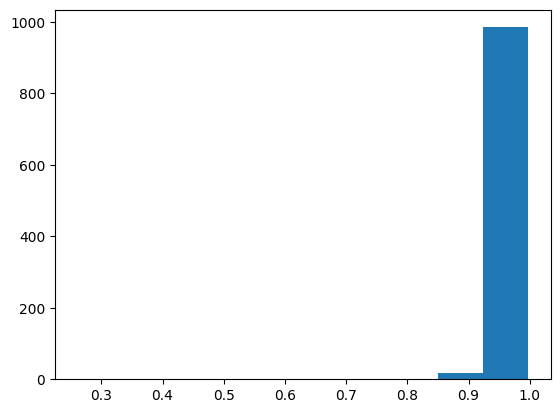

In [228]:
recs, guesses = check_clusters(original_strands, clusters[:1004], sampled_reads)
plt.hist(recs)

In [237]:
recs, guesses_ = check_clusters(original_strands, clusters[:1004], sampled_reads, make_guess=True)
guesses

  0%|          | 0/1004 [00:00<?, ?it/s]

['CGGATAGTTACCTAACCTCCAATTCTCGCCACTATGATTACAGATTGCGCGATGTGTGTGCCGCGATCAATTGAACTATCCCGTCCTGCCAAGTTGCGTAAGTTGTGCTCTGAAAATCTAGGCCATGGGCCATCCCAATAACCCTGAACATATGGTTGTTCTTGGTAGACCTGTCACCCGAAAATCCCCAGTGGAGATG',
 'GCTATGCGGGCGATAATATCACCTAGACAGCCCCTAGATTCGTATTGCTCGGTCGGCCCGAACAATAACCAGCAAACGCCGTAGCCCCGAAACAACGTCCGAATGTGCTGCCGAGTCCAAGTGCGAATCGTTTGTTGGGCTTTAGCGATCGATTTAGAGCCTGAACCAATCTCGTTGAGACGAGGTGGAGAGTTAAGCC',
 'ATGAACCATGGAGGTAATCTAATCAGTGAGTACATACAGTGGGTAAAGCAACAGACTCAGCCTTTGCGCAACCGATGGCTAGAATCTTAGAGTTGTGCTGCCTATTAATACTCGCACCTCCCGTACGTTTTCTTAATCACACAGGTACGAAGCCAGTGCTCCCTTATTCTGGAGAGGTCGGAAGATGCCGATAAATCAAC',
 'AGTTAATAGTAATAGGCCTAATCGGACGCCACTCCCCGGTCCCTAGAATTGGGAGAGCAAAACACATCGCGCTTTCATGCATCAGTTTTAGGGCTGCACCTCCGTCATGGTAGTACGGGCGGCGCTCGGTCTGCCAATCCACACATTCCCCTAACCAATCCATGAAATTAGAGAATTGGCAAAAGATGTTGCAATAGTGA',
 'GCGTATTGCTGCAATGCTATAGCACGCCGTCAGTGGCAATTGATATGGGCTAACGGTTGCTCCGCGATTGACGAACATATGACGTTCGGCATTACTAGTCGTTTAAGAGCCCGGGGCGTATGTATGGGTGTAGATTTACCTGCTTGCCGTCGGGTGGCTTTGTACTGTAGCCGTATAGGT

In [239]:

for cluster, guess in zip(clusters, guesses_):
    strand_id = sampled_ids[cluster[0]]
    
    if strand_id == 'junk_seq' or strand_id == 'random_seq':
        continue
    
    original_strand_index = original_strand_ids.index(strand_id)
    reference = original_strands[original_strand_index]

    cluster_head = guess
    print(len(cluster_head))
    print(ratio(cluster_head, reference))
    print(utils.get_recovery_percentage(cluster_head, reference))
    print(utils.align(cluster_head, reference, identity=False).format())

    print(ratio(cluster_head[post_clustering.remove_adapter(cluster_head[:30], start_adapter):], reference))
    print(utils.get_recovery_percentage(cluster_head[post_clustering.remove_adapter(cluster_head[:30], start_adapter):], reference))

    rec_1 = utils.get_recovery_percentage(reference, cluster_head)
    rec_2 = utils.get_recovery_percentage(reference, utils.reverse_complement(cluster_head))

    if rec_1 > rec_2:
        guesses.append(cluster_head)
    else:
        guesses.append(utils.reverse_complement(cluster_head))
    
    recs.append(max([rec_1, rec_2]))

    print()

    

208
0.9656862745098039
0.33
target            0 CGGATAGTTACCTAACCTCGAATTCTCGGGCCACTATGATTACAGATTGCGCGACGTCTG
                  0 |||||||||||||||||||||||||||--|||||||||||||||||||||||||||||||
query             0 CGGATAGTTACCTAACCTCGAATTCTC--GCCACTATGATTACAGATTGCGCGACGTCTG

target           60 TGCCGCGATCAATTGAACTATCCCGTCCTGCCAAGTTGCGTAAGTTGTGCTTGAAAATCT
                 60 ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
query            58 TGCCGCGATCAATTGAACTATCCCGTCCTGCCAAGTTGCGTAAGTTGTGCTTGAAAATCT

target          120 AGGCCGGATGGGCCATCCCAATTGAACCCTGAACATATGGTTGTTCTTGGGGAAACCTGT
                120 |||||--|||||||||||||||--|||||||||||||||||||||||||||||.||||||
query           118 AGGCC--ATGGGCCATCCCAAT--AACCCTGAACATATGGTTGTTCTTGGGGAGACCTGT

target          180 CACCCGAAAATCCCAGTGTAG-G-GTTCCG 208
                180 |||||||||||||||||||||-|---|--| 210
query           174 CACCCGAAAATCCCAGTGTAGAGA--T--G 200

0.9370277078085643
0.265

212
0.9174757281553398
0.32
target            0 

In [209]:
import uuid

guess_ids = [str(uuid.uuid4()) for i in range(len(original_strands))]
utils.create_fasta_file(guess_ids, guesses, output_filepath='raptor_data/guesses.fasta')

In [197]:
recs

[0.9674185463659148,
 0.9824561403508771,
 0.985,
 0.98,
 0.935,
 0.97,
 0.955,
 0.985,
 0.9299999999999999,
 0.9776674937965261,
 0.985,
 0.91,
 0.975,
 0.955,
 0.9724310776942355,
 0.99,
 0.9724310776942355,
 0.9624060150375939,
 0.965,
 0.98,
 0.98,
 0.9924812030075187,
 0.99,
 0.98,
 0.94,
 0.99,
 0.985,
 0.987468671679198,
 0.9774436090225564,
 0.9824561403508771,
 0.9875311720698254,
 0.9824561403508771,
 0.985,
 0.9774436090225564,
 0.97,
 0.9573934837092732,
 0.945,
 0.9727047146401985,
 0.975,
 0.96,
 0.985,
 0.9800995024875622,
 0.9724310776942355,
 0.9875930521091811,
 0.955,
 0.98,
 0.987468671679198,
 0.98,
 0.987468671679198,
 0.99,
 0.9624060150375939,
 0.935,
 0.96,
 0.987468671679198,
 0.9523809523809523,
 0.98,
 0.985,
 0.98,
 0.96,
 0.987468671679198,
 0.965,
 0.975,
 0.987468671679198,
 0.985,
 0.955,
 0.985,
 0.985,
 0.925,
 0.975,
 0.9850746268656716,
 0.98,
 0.98,
 0.987468671679198,
 0.9850746268656716,
 0.9900497512437811,
 0.985,
 0.9824561403508771,
 0.982456

In [103]:
clusters_by_index = np.zeros(len(original_strands))

for i in clusters[:1004]:
    try:
        clusters_by_index[original_strand_ids.index(sampled_ids[i[0]])] += 1
    except:
        continue

print("Number of repeated cluster heads")
print(sum([1 for i in clusters_by_index if i > 1]))

print("Average strands in top n clusters")
print(np.mean(cluster_lens))

print("Min strands in top n clusters")
print(np.min(cluster_lens))

Number of repeated cluster heads
4
Average strands in top n clusters
14.203187250996017
Min strands in top n clusters
5


In [173]:


def get_best_candidates_and_recoveries(original_strands, candidates):
    """
    For a given set of strands, finds the best candidates and returns a dictionary with
    the recoveries, the number of fully recovered strands, the best set of candidates and the
    original strands
    """
    
    fully_recovered_strands = 0
    recoveries = []
    partially_recovered_recoveries = []
    best_candidates = []

    for strand in tqdm(original_strands):
        if strand in candidates:
            fully_recovered_strands += 1
            recoveries.append(1.0)
            best_candidates.append(strand)
        else:
            best_recovery_within_candidates = 0.0
            best_candidate = ""
            for candidate in candidates:
                rev_candidate = utils.reverse_complement(candidate)
                strand_recovery = ratio(candidate, strand)

                if strand_recovery > best_recovery_within_candidates:
                    best_recovery_within_candidates = strand_recovery
                    best_candidate = candidate

                strand_recovery = ratio(rev_candidate, strand)

                if strand_recovery > best_recovery_within_candidates:
                    best_recovery_within_candidates = strand_recovery
                    best_candidate = candidate

            recoveries.append(best_recovery_within_candidates)
            partially_recovered_recoveries.append(best_recovery_within_candidates)
            best_candidates.append(best_candidate)

    return {
        "recoveries": recoveries,
        "fully_recovered_strands": fully_recovered_strands,
        "partially_recovered_recoveries": partially_recovered_recoveries,
        "best_candidates": best_candidates,
        "original_strands": original_strands
    }


def check_clusters(original_strands, original_strand_ids, strand_ids, cluster_inds, centroids):

    recoveries = []
    for ind, i in enumerate(cluster_inds):
        cluster_strand_id = strand_ids[i[0]]

        if cluster_strand_id == 'random_seq' or cluster_strand_id == 'junk_seq':
            continue
        
        rat1 = ratio(centroids[ind], original_strands[original_strand_ids.index(cluster_strand_id)])
        print(rat1)
        rat2 = ratio(utils.reverse_complement(centroids[ind]), original_strands[original_strand_ids.index(cluster_strand_id)])
        print(rat2)
        print()

        recoveries.append(max(rat1, rat2))
        

    return recoveries


In [174]:
recs = check_clusters(original_strands, original_strand_ids, sampled_ids, clusters, centroids)

0.631578947368421
0.9674185463659148

0.9824561403508771
0.6566416040100251

0.985
0.625

0.605
0.645

0.63
0.63

0.625
0.64

0.63
0.955

0.985
0.675

0.62
0.9299999999999999

0.9776674937965261
0.6501240694789081

0.625
0.985

0.91
0.63

0.645
0.975

0.635
0.6699999999999999

0.62
0.635

0.6466165413533835
0.6466165413533835

0.6566416040100251
0.9724310776942355

0.9624060150375939
0.6566416040100251

0.965
0.6599999999999999

0.64
0.98

0.65
0.98

0.6065162907268171
0.9924812030075187

0.655
0.99

0.98
0.64

0.64
0.94

0.65
0.99

0.985
0.665

0.987468671679198
0.7017543859649122

0.6566416040100251
0.9774436090225564

0.9824561403508771
0.6566416040100251

0.6234413965087282
0.9875311720698254

0.6466165413533835
0.9824561403508771

0.985
0.645

0.6416040100250626
0.9774436090225564

0.625
0.97

0.6416040100250626
0.9573934837092732

0.645
0.945

0.6451612903225806
0.9727047146401985

0.975
0.645

0.96
0.6599999999999999

0.645
0.985

0.6517412935323383
0.9800995024875622

0.6516290

(array([  1.,   0.,   0.,   2.,  88., 703.,  10.,  49.,  90., 249.]),
 array([0.26086957, 0.33428261, 0.40769565, 0.4811087 , 0.55452174,
        0.62793478, 0.70134783, 0.77476087, 0.84817391, 0.92158696,
        0.995     ]),
 <BarContainer object of 10 artists>)

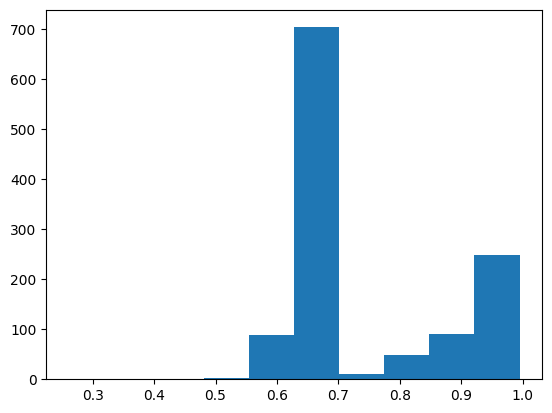

In [175]:
plt.hist(recs)

In [161]:
recs = get_best_candidates_and_recoveries(original_strands, centroids[:1004])

  0%|          | 0/1004 [00:00<?, ?it/s]

(array([  3.,   0.,   0.,   0.,   0.,   0.,   2.,  31., 137., 831.]),
 array([0.68      , 0.71174937, 0.74349875, 0.77524812, 0.80699749,
        0.83874687, 0.87049624, 0.90224561, 0.93399499, 0.96574436,
        0.99749373]),
 <BarContainer object of 10 artists>)

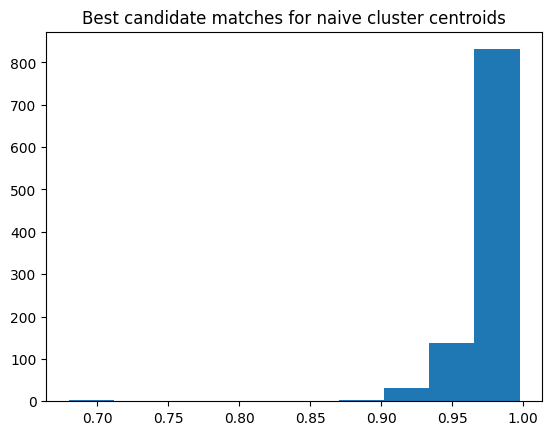

In [164]:
plt.title("Best candidate matches for naive cluster centroids")
plt.hist(recs['recoveries'])

(0.0, 1.0)

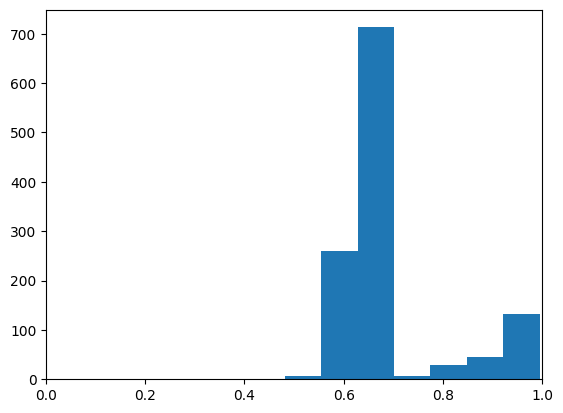

In [155]:
plt.hist(recs)
plt.xlim(0, 1)

In [ ]:
recs2 = get_best_candidates_and_recoveries(original_strands, clus)

In [60]:
centroid_indices = [i[0] for i in cluster_inds]
centroid_records = [sampled[j] for j in centroid_indices][:1004]

centroid_stats = utils.get_sample_statistics(records = centroid_records, original_strands=original_strands, original_strand_ids=ids, reference=True, distance_threshold=40)

100%|██████████| 1004/1004 [00:00<00:00, 24248.58it/s]


In [61]:
centroid_stats

{'distance_threshold': 40,
 'strands_by_index': array([1., 1., 1., ..., 1., 1., 1.]),
 'mean_strands_per_index': 0.9800796812749004,
 'std_strands_per_index': 0.3860123979098825,
 'unique_matches': 919,
 'n_straight': 444,
 'n_reverse': 540,
 'unmatched': 20}

In [63]:
guesses = []
for i in tqdm(range(1000)):
    guesses.append(heirarchal_clustering.make_prediction(clustered_seqs[i], 5))

  0%|          | 0/1000 [00:00<?, ?it/s]

ValueError: Sample larger than population or is negative

In [ ]:

distance_threshold = 40

strands_by_index = np.zeros(len(original_strands))
straight_strands = 0
reverse_strands = 0

for ind, i in enumerate(guesses):

    revseq = utils.reverse_complement(i)

    record = sampled[cluster_inds[ind][0]]

    strand_id = utils.get_badread_strand_id(record)
    #synthesized_id = strand_ids_synthesized[strand_id]
    #index = original_strand_ids.index(synthesized_id)
    index = ids.index(strand_id)
    strand = original_strands[index]

    if distance(i, strand) <= distance_threshold:
        strands_by_index[index] += 1
        straight_strands += 1
        found_flag = True
        print(f"{index} found by {ind}")

    elif distance(revseq, strand) <= distance_threshold:
        strands_by_index[index] += 1
        reverse_strands += 1
        found_flag = True
        print(f"{index} found by r{ind}")

833 found by 0
392 found by r1
197 found by r2
147 found by r4
372 found by r7
933 found by 8
945 found by r9
896 found by 10
876 found by r11
322 found by 12
468 found by 13
705 found by r14
777 found by 15
492 found by 16
669 found by r17
901 found by 18
388 found by r19
217 found by 20
476 found by 36
446 found by 45
304 found by 46
544 found by 47
46 found by 48
187 found by r49
971 found by 50
639 found by r51
814 found by 52
161 found by r53
265 found by r54
843 found by r55
327 found by r56
564 found by 57
838 found by r58
683 found by 59
520 found by r60
359 found by r61
723 found by 62
882 found by r63
425 found by 155
754 found by r156
34 found by r157
956 found by 158
365 found by r159
608 found by r160
986 found by r161
212 found by r162
10 found by r163
94 found by 164
988 found by r165
373 found by 371
306 found by r618
936 found by 619
310 found by r620
214 found by r621
743 found by 622
70 found by r623
637 found by r624
847 found by r625
281 found by 626
676 found by 6